In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/OceanChalenge/ocean_v5_fondos.zip

In [ ]:
!cp drive/MyDrive/OceanChalenge/ocean_dataset.csv .

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Loading dataset

In [ ]:
PATH = 'drive/MyDrive/OceanChalenge'

In [ ]:
CLASES = ['fangoso', 'arenoso', 'arenofangoso', 'arrecife']

In [ ]:
dataframe = pd.read_csv('ocean_dataset.csv')
n = round(len(dataframe) * 0.7)
train_data = dataframe.iloc[:n]
test_data = dataframe.iloc[n:]
test_data

,filenames,labels
2383,ocean_v2/arenoso/b84a130281faf1c813e3511d90d97...,1
2384,ocean_v2/fangoso/fc43c3112f8d67d9ce091b1a03b5f...,0
2385,ocean_v2/arenoso/884e1806a45ca8a6e59baaa6c20ed...,1
2386,ocean_v2/arenofangoso/e82cf5f585a4fcdcaca9d83b...,2
2387,ocean_v2/fangoso/b21252e8f014745455af137c9c126...,0
...,...,...
3399,ocean_v2/arenofangoso/0394664c90346b7d4ecc7d5e...,2
3400,ocean_v2/arrecife/4cfe8ad86db0ded4ecda972ddc31...,3
3401,ocean_v2/arenoso/4a0ff288f0127b572b65d66bfb529...,1
3402,ocean_v2/arenoso/124a422afd8044de8e8470e40b8d0...,1


In [ ]:
def load_image(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (480, 270), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.float32(img / 255)
    return img

In [ ]:
def random_crop(input_image):
    cropped_image = tf.image.random_crop(
        input_image,
        size=(256, 256, 3))
    return cropped_image

def normalize(input_image):
    input_image = (input_image * 2) - 1
    return input_image

@tf.function()
def random_jitter(input_image, label):
    # randomly cropping to 256 x 256 x 3
    input_image = random_crop(input_image)
    input_image = tf.image.random_brightness(input_image, 0.1)
    input_image = tf.image.random_contrast(input_image, 1, 1.2)
    if tf.random.uniform([1]) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
    input_image = normalize(input_image)
    return input_image, label

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast([load_image(filename) for filename in train_data['filenames']], tf.float32), 
     tf.cast(train_data['labels'], tf.float32))
).map(random_jitter).shuffle(400).repeat().take(10000).batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast([load_image(filename) for filename in test_data['filenames']], tf.float32), 
     tf.cast(test_data['labels'], tf.float32))
).map(random_jitter).batch(BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


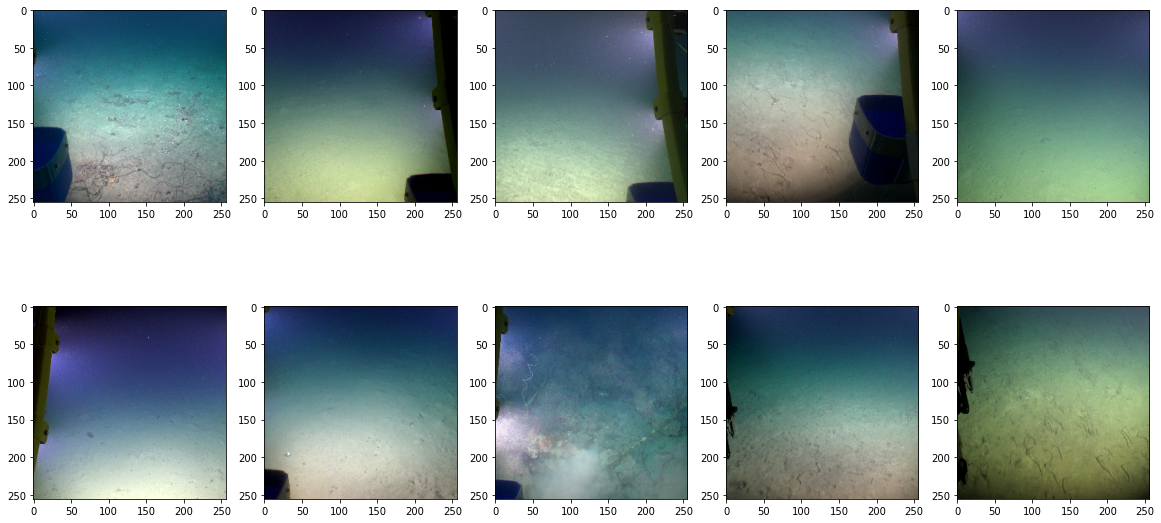

In [ ]:
  plt.figure(figsize=(20, 10))
for inp, tar in test_dataset.take(1):
    for i, img in enumerate(inp[:10]):
        img = (img + 1) / 2
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
plt.show()

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

In [ ]:
# Model
initializer = tf.random_normal_initializer(0., 0.02)
def create_model():
    inputs = layers.Input(shape=[256,256,3])
    X = tf.keras.layers.experimental.preprocessing.RandomRotation(0.5)(inputs)
    X = layers.Conv2D(2**4, 3, padding='same', activation='relu', kernel_initializer=initializer)(X)
    X = layers.MaxPooling2D()(X) # shape 128 x 128
    X = layers.Conv2D(2**5, 3, padding='same', activation='relu', kernel_initializer=initializer)(X)
    X = layers.MaxPooling2D()(X)# shape 64 x 64
    X = layers.Conv2D(2**6, 3, padding='same', activation='relu', kernel_initializer=initializer)(X)
    X = layers.MaxPooling2D()(X)# shape 32 x 32
    X = layers.Conv2D(2**7, 3, padding='same', activation='relu', kernel_initializer=initializer)(X)
    X = layers.MaxPooling2D()(X)# shape 16 x 16
    X = layers.Conv2D(2**8, 3, padding='same', activation='relu', kernel_initializer=initializer)(X)
    X = layers.MaxPooling2D()(X)# shape 8 x 8
    X = layers.Conv2D(2**8, 3, padding='same', activation='relu', kernel_initializer=initializer)(X)
    X = layers.MaxPooling2D()(X)# shape 4 x 4
    X = layers.Conv2D(2**8, 3, padding='same', activation='relu', kernel_initializer=initializer)(X)
    X = layers.MaxPooling2D()(X)# shape 2 x 2
    X = layers.Conv2D(2**8, 3, padding='same', activation='relu', kernel_initializer=initializer)(X)
    X = layers.MaxPooling2D()(X)# shape 1 x 1
    X = layers.Flatten()(X)
    X = layers.Dense(128, activation='relu')(X)
    Y = layers.Dense(len(CLASES))(X)

    model = models.Model(inputs=inputs, outputs=Y)
    return model


In [ ]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496 

In [ ]:
import time

In [ ]:
start = time.time()
Y = model(inp)
print(f'time: {time.time() - start}')

time: 0.029013395309448242


In [ ]:
#strategy = tf.distribute.experimental.CentralStorageStrategy()
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
with strategy.scope():
    model = create_model()
    optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE)
    loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy('training_loss', dtype=tf.float32)
    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy('training_acc', dtype=tf.float32)

In [ ]:
checkpoint_dir = os.path.join(PATH, 'training_checkpoints')
ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
ckpt = tf.train.Checkpoint(optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_prefix, max_to_keep=5)

In [ ]:
manager.restore_or_initialize()

'drive/MyDrive/OceanChalenge/training_checkpoints/ckpt/ckpt-29'

In [ ]:
history_dir = os.path.join(PATH, 'history_ocean_training.csv')
if os.path.exists(history_dir):
    history = pd.read_csv(history_dir)
else:
    history = pd.DataFrame()

In [ ]:
history

,acc,epoch,loss,val_acc,val_loss
0,0.693042,0.0,1.929435,0.754474,1.021253
1,0.778656,1.0,0.957071,0.788761,0.845228
2,0.853475,0.0,0.653594,0.890181,0.575008
3,0.898097,1.0,0.539148,0.918356,0.540006


In [ ]:
@tf.function()
def train_step(X, target):
    with tf.GradientTape() as tape:
        Y = model(X, training=True)
        loss = loss_object(y_true=target, y_pred=Y)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    loss_metric.update_state(target, Y)
    acc_metric.update_state(target, Y)

@tf.function()
def test_step(X, target):
    Y = model(X)
    loss = loss_object(y_true=target, y_pred=Y)
    loss_metric.update_state(target, Y)
    acc_metric.update_state(target, Y)

In [ ]:
def fit(train_dataset, test_dataset, epochs=1, size=len(train_data)//BATCH_SIZE):
    global history
    print(f'Modelo restaurado de: {manager.restore_or_initialize()}')
    for epoch in range(epochs):
        start = time.time()
        for step, (X, target) in enumerate(train_dataset):
            strategy.run(train_step, args=(X, target))
            loss = loss_metric.result()
            acc = acc_metric.result()
            print("\rStep: %5d/%d loss: %.3f acc: %.4f" % (step+1, size, loss, acc), end="")
        print(f'\nEpoch: (%3d/%d) Train result | acc: %.3f'
               % (epoch+1, epochs, acc),
              f'| loss: %.5f' % (loss_metric.result()),
              f'| time: %.3f' % (time.time()-start))
        
        if (epoch + 1) % 5 == 0:
            train_loss = loss_metric.result()
            train_acc = acc_metric.result()
            acc_metric.reset_states()
            loss_metric.reset_states()
            for step, (X, target) in enumerate(test_dataset):
                strategy.run(test_step, args=(X, target))
                loss = loss_metric.result()
                acc = acc_metric.result()
                print("\rTest step: %5d/%d loss: %.3f acc: %.4f" 
                      % (step+1, len(test_data) // BATCH_SIZE, loss, acc), end="")
            print(f'\nEpoch: (%3d/%d) Test result | acc: %.3f'
                    % (epoch+1, epochs, acc),
                    f'| loss: %.5f' % (loss_metric.result()),
                    f'| time: %.3f' % (time.time()-start))
            
            history = history.append({
                'epoch': epoch,
                'loss':float(train_loss),
                'acc': float(train_acc),
                'val_loss': float(loss),
                'val_acc': float(acc)}, ignore_index=True)
            history.to_csv(history_dir, index=False)
            seved_dir = manager.save()
            print(f'modelo guardadeo en {seved_dir}')
        acc_metric.reset_states()
        loss_metric.reset_states()

In [ ]:
start = time.time()
strategy.run(train_step, args=(inp, tar))
print(f'time: {time.time() - start}')
loss_metric.result()
#loss_metric.reset_states()

time: 3.0003316402435303


<tf.Tensor: shape=(), dtype=float32, numpy=0.3275783>

In [ ]:
dataset = strategy.experimental_distribute_datasets_from_function(
    lambda _: train_dataset
)

Instructions for updating:
rename to distribute_datasets_from_function


In [ ]:
fit(dataset, test_dataset, epochs=1, size=10000//BATCH_SIZE)

Modelo restaurado de: drive/MyDrive/OceanChalenge/training_checkpoints/ckpt/ckpt-29
Step:   157/156 loss: 0.324 acc: 0.9697
Epoch: (  1/1) Train result | acc: 0.970 | loss: 0.32409 | time: 38.576


In [ ]:
model.save(os.path.join(PATH, 'fondos_model_v1.h5')) # ckpt-29